# PointNet++ in PyTorch Geometric

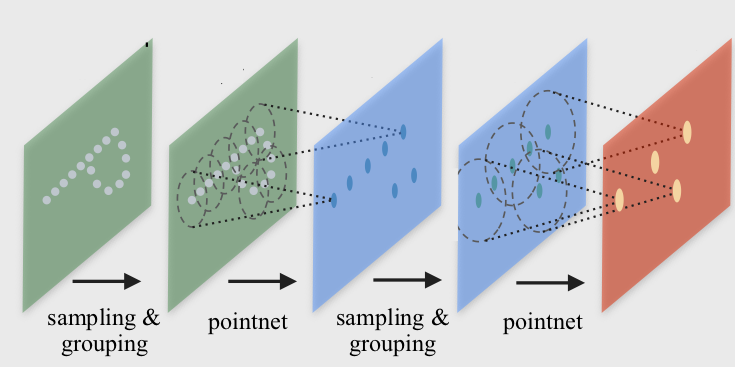

In [73]:
%matplotlib inline
from utils import visualize

import torch
torch.manual_seed(5);

## Data Handling

In [74]:
from torch_geometric.datasets import GeometricShapes
from torch_geometric.data import DataLoader

dataset = GeometricShapes(root='/tmp/geometric_shapes')

# Filter dataset to only contain a circle and a square.
dataset = dataset[torch.tensor([0, 4])]

loader = DataLoader(dataset, batch_size=2, shuffle=False)

data = next(iter(loader))  # Get first mini-batch.

Batch(batch=[36], face=[3, 32], pos=[36, 3], y=[2])


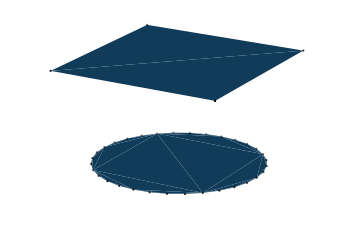

In [75]:
print(data)
visualize(data, size=(6,6))

## Point Cloud Generation

In [76]:
import torch_geometric.transforms as T

dataset.transform = T.SamplePoints(num=256)

Batch(batch=[512], pos=[512, 3], y=[2])


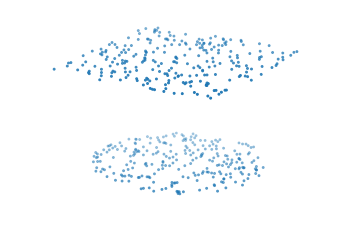

In [77]:
print(next(iter(loader)))
visualize(next(iter(loader)), size=(6,6))

## Farthest Point Sampling

In [78]:
dataset.transform = T.SamplePoints(num=128)
data = next(iter(loader))  # Get first mini-batch.

In [79]:
from torch_geometric.nn import fps

mask = fps(data.pos, data.batch, ratio=0.25)

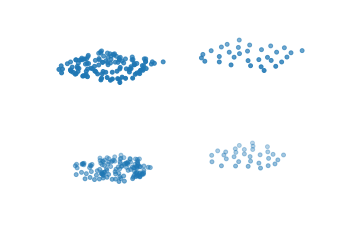

In [80]:
visualize(data, mask, size=(8,5))

## Grouping via Dynamic Graph Generation

In [81]:
# Create radius graph.
from torch_geometric.nn import radius

assign_index = radius(data.pos, data.pos[mask], 0.4,
                      data.batch, data.batch[mask])

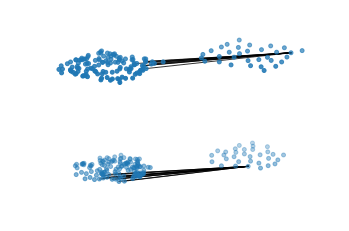

In [82]:
visualize(data, mask, assign_index, size=(8,5))

## First PointNet layer

$\vec{x}^{\prime}_i = \max_{j \in \mathcal{N}(i)} \textrm{MLP} \left( \vec{p}_j - \vec{p}_i \right)$

* $\vec{p}_i \in \mathbb{R}^3$ denotes the **pos**ition of each point $i$

In [83]:
import torch
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import MessagePassing

class PointNetLayer(MessagePassing):
    def __init__(self, in_dim, out_dim):
        # Message passing with max aggregation.
        super(PointNetLayer, self).__init__('max')
        
        # Initialize a MLP.
        self.mlp = Sequential(Linear(in_dim, out_dim),
                              ReLU(),
                              Linear(out_dim, out_dim))
        
    def forward(self, pos, pos_sampled, assign_index):
        # Start propagating messages.
        return self.propagate(assign_index, pos=(pos, pos_sampled))
    
    def message(self, pos_j, pos_i):
        # Generate messages.
        return self.mlp(pos_j - pos_i)  

## Network Architecture

In [84]:
import torch.nn.functional as F
from torch_geometric.nn import global_max_pool

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv = PointNetLayer(3, 32)
        self.classifier = Linear(32, dataset.num_classes)
        
    def forward(self, pos, batch):
        # 1. Sample farthest points.
        mask = fps(pos, batch, ratio=0.25)
        
        # 2. Dynamically generate message passing connections.
        row, col = radius(pos, pos[mask], 0.3, batch, batch[mask])
        assign_index = torch.stack([col, row], dim=0)  # Transpose.
        
        # 3. Start bipartite message passing.
        x = self.conv(pos, pos[mask], assign_index)
       
        # 4. Global Pooling.
        x = global_max_pool(x, batch[mask])
        
        # 5. Classifier.
        return self.classifier(x)

## Training Procedure

In [85]:
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        # data = data.to(torch.device('cuda'))
        out = model(data.pos, data.batch)
        loss = F.nll_loss(F.log_softmax(out, dim=1), data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

for epoch in range(1, 10):
    loss = train()
    print('Epoch: {:01d}, Loss: {:.4f}'.format(epoch, loss))

Epoch: 1, Loss: 1.7823
Epoch: 2, Loss: 1.6134
Epoch: 3, Loss: 1.4659
Epoch: 4, Loss: 1.3258
Epoch: 5, Loss: 1.1924
Epoch: 6, Loss: 1.0676
Epoch: 7, Loss: 0.9586
Epoch: 8, Loss: 0.8692
Epoch: 9, Loss: 0.8021
